В цьому наборі завдань закріпимо те, що було на лекції з Computer Vision.

# Computer Vision with PyTorch Excercises. Solution


## 1. Наведіть 3 галузі промисловості, де комп'ютерний зір використовується сьогодні (можна згадати з лекції, або провести міні-рісерч).

сільське господарство, виробництво машин (один з прикладів тесла), відео спостереження (як вимірювання швидкості машин так і розпізнавання обич)

## 2. Виділіть 20 хвилин аби ознайомитись та переглянути сайт [CNN Explainer](https://poloclub.github.io/cnn-explainer/).

* Завантажте власне будь-яке зображення за допомогою кнопки Upload" на сайті та подивіться, що відбувається на кожному шарі CNN, коли ваше зображення проходить через нього.

Напишіть 3 пункти, що ви дізнались після цієї вправи?

## 3. Завантажте навчальні та тестові набори даних [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST).

MNIST - базовий набір даних для задач Computer Vision. Часто використовується для навчання.

- Виведіть, скільки елементів в кожному наборі.
- Покажіть формат (розмірності) кожної картинки.
- Виведіть, які класи представлені в цьому наборі даних.

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]


In [2]:
print(f"Кількість зображень у train: {len(train_dataset)}")
print(f"Кількість зображень у test: {len(test_dataset)}")

sample_image, sample_label = train_dataset[0]
print(f"Розмірність одного зображення: {sample_image.shape}")

classes = train_dataset.classes  # ['0', '1', ..., '9']
print(f"Класи в наборі MNIST: {classes}")

Кількість зображень у train: 60000
Кількість зображень у test: 10000
Розмірність одного зображення: torch.Size([1, 28, 28])
Класи в наборі MNIST: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


## 4. Візуалізуйте щонайменше 5 різних зразків з навчального набору даних MNIST.

Image shape: torch.Size([1, 28, 28])


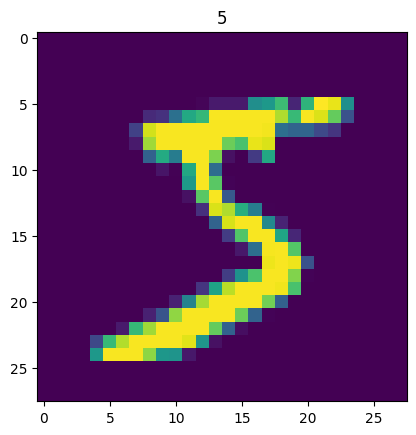

In [3]:
import matplotlib.pyplot as plt
image, label = train_dataset[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # форма зображення - [1, 28, 28] (кольорові канали, висота, ширина)
plt.title(label);

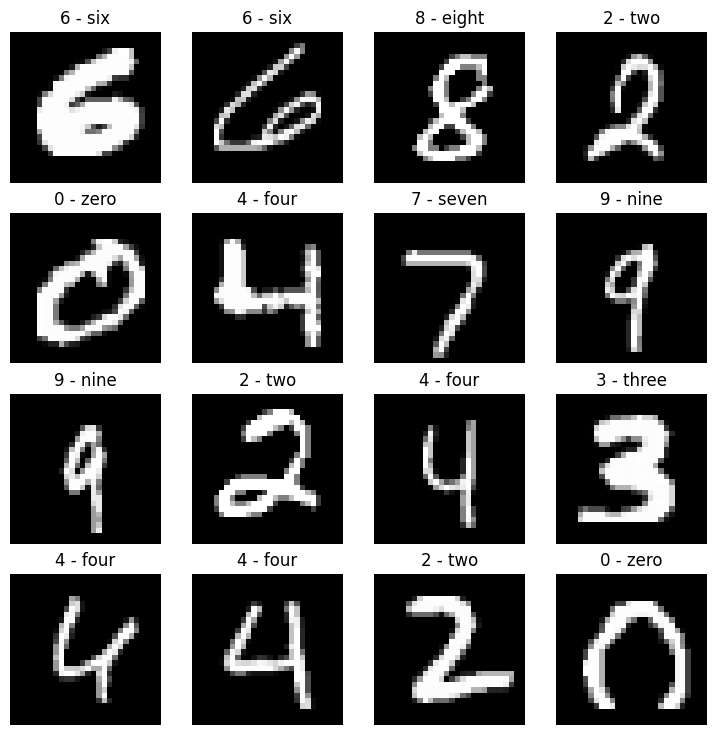

In [4]:
# Відобразити більше зображень
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(classes[label])
    plt.axis(False);

## 5. Перетворіть навчальні та тестові набори даних MNIST у data loaders за допомогою `torch.utils.data.DataLoader`, встановіть `batch_size=32`.
- Покажіть, яку форму даних вертають дата лоадери.

In [5]:
from torch.utils.data import DataLoader

# Налаштування гіперпараметра розміру партії
BATCH_SIZE = 32

# Перетворення наборів даних на ітерабельні (партії)
train_dataloader = DataLoader(train_dataset, # набір даних, який потрібно перетворити на ітерабельний
    batch_size=BATCH_SIZE, # скільки зразків на партію?
    shuffle=True # перемішувати дані на кожній епосі?
)

test_dataloader = DataLoader(test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # не обов'язково перемішувати тестові дані
)

# Давайте перевіримо, що ми створили
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Довжина навчального dataloader: {len(train_dataloader)} партій по {BATCH_SIZE}")
print(f"Довжина тестового dataloader: {len(test_dataloader)} партій по {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7a27758daae0>, <torch.utils.data.dataloader.DataLoader object at 0x7a27759398b0>)
Довжина навчального dataloader: 1875 партій по 32
Довжина тестового dataloader: 313 партій по 32


In [6]:
# Перевірте, що всередині навчального dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 6. Відтворіть `ModelV2`, яку ми розглядали на лекції
Це до слова та сама модель з [сайту CNN Explainer](https://poloclub.github.io/cnn-explainer/), також відома як TinyVGG і вона здатна навчатися на наборі даних MNIST.

Напишіть клас моделі.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Створення згорткової нейронної мережі
class FashionMNISTModelV2(nn.Module):
    """
    Архітектура моделі, що копіює TinyVGG з:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # якого розміру квадрат, що проходить по зображенню?
                      stride=1, # за замовчуванням
                      padding=1),# варіанти = "valid" (без заповнення) або "same" (вихід має таку ж форму, як вхід) або int для конкретного числа
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # значення кроку за замовчуванням таке ж, як і розмір ядра
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Звідки взялася ця форма in_features?
            # Це тому, що кожен шар нашої мережі стискає та змінює форму наших вхідних даних.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x


## 7. Навчіть модель, яку ви побудували в попередній вправі, протягом 5 епох на CPU та GPU і подивіться, скільки часу це займе в кожному з варіантів.

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import time

transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root=".", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class ModelV2(nn.Module):
    def __init__(self):
        super(ModelV2, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 10)
        )
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return self.classifier(x)

def train_model(device):
    model = ModelV2().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start = time.time()

    for epoch in range(5):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

    end = time.time()
    duration = end - start
    print(f"Training on {device} took {duration:.2f} seconds.")
    return duration

print("\nTraining on CPU")
train_model(torch.device("cpu"))

if torch.cuda.is_available():
    print("\nTraining on GPU")
    train_model(torch.device("cuda"))
else:
    print("\nGPU not available.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.4MB/s]



Training on CPU
Epoch 1: Loss = 313.6606
Epoch 2: Loss = 92.8651
Epoch 3: Loss = 68.2442
Epoch 4: Loss = 54.5281
Epoch 5: Loss = 45.4337
Training on cpu took 271.72 seconds.

Training on GPU
Epoch 1: Loss = 301.7726
Epoch 2: Loss = 96.4498
Epoch 3: Loss = 70.0916
Epoch 4: Loss = 52.0396
Epoch 5: Loss = 45.1015
Training on cuda took 59.76 seconds.


## 8. Зробіть прогнози за допомогою вашої навченої моделі та візуалізуйте принаймні 5 з них, порівнюючи прогноз з цільовою міткою.

In [10]:
import matplotlib.pyplot as plt

def show_predictions(model, dataloader, device, n_images=6):
    model.to(device)
    model.eval()

    images_shown = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            for i in range(images.size(0)):
                plt.subplot(2, 3, images_shown + 1)
                plt.imshow(images[i].cpu().squeeze(), cmap="gray")
                plt.title(f"Pred: {preds[i].item()}, True: {labels[i].item()}")
                plt.axis("off")

                images_shown += 1
                if images_shown == n_images:
                    plt.show()
                    return

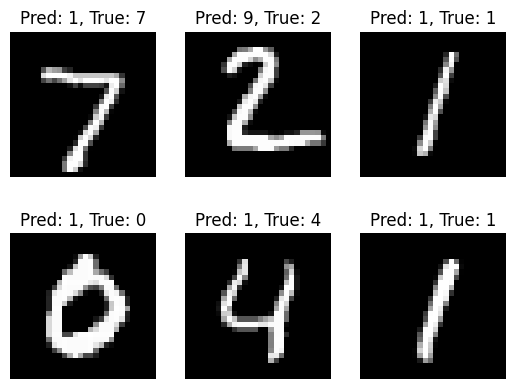

In [11]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

test_data = torchvision.datasets.MNIST(root=".",
                                       train=False,
                                       transform=transforms.ToTensor(),
                                       download=True)

test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class ModelV2(nn.Module):
    def __init__(self):
        super(ModelV2, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

model = ModelV2()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
show_predictions(model, test_loader, device)

## 9. Побудуйте матрицю плутанини, порівнюючи передбачення вашої моделі з істинними мітками.

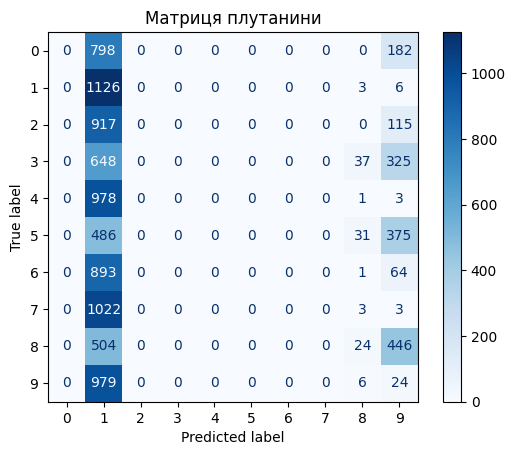

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_and_plot_conf_matrix(model, dataloader, device):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Матриця плутанини")
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluate_and_plot_conf_matrix(model, test_loader, device)

## 10. Виведіть принаймні 9 прикладів, де модель помиляється, разом з тим, якою мала бути мітка зображення.
* Після візуалізації цих прогнозів, як ви думаєте, це більше помилка моделювання чи помилка даних?
* Тобто, чи може модель працювати краще, чи мітки даних занадто близькі одна до одної, що навіть людина не може чітко розрізнити що це за цифра?

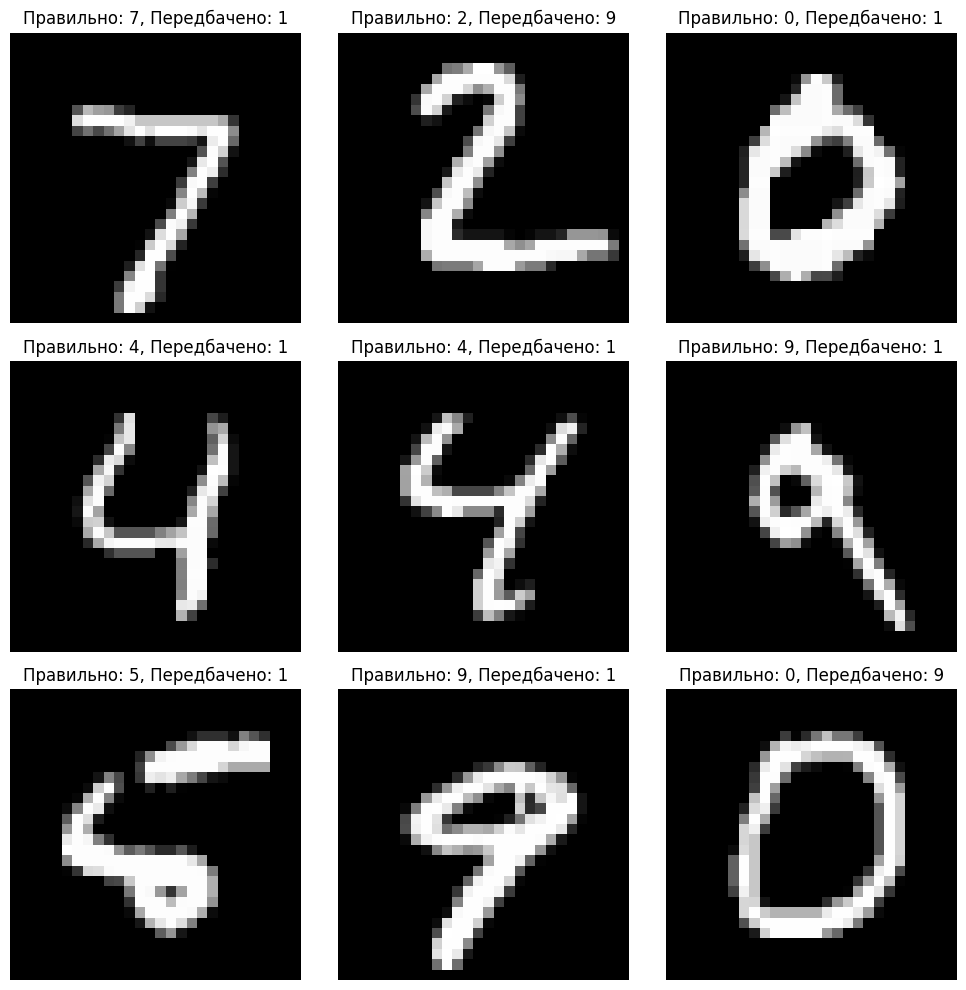

In [13]:
def show_misclassified(model, dataloader, device, num_examples=9):
    model.eval()
    model.to(device)

    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for img, pred, label in zip(images, preds, labels):
                if pred != label:
                    misclassified.append((img.cpu(), label.cpu(), pred.cpu()))
                    if len(misclassified) >= num_examples:
                        break
            if len(misclassified) >= num_examples:
                break

    plt.figure(figsize=(10, 10))
    for i, (img, label, pred) in enumerate(misclassified):
        plt.subplot(3, 3, i+1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(f"Правильно: {label}, Передбачено: {pred}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
show_misclassified(model, test_loader, device)

Якщо зображення цифр виглядають розмитими, некоректно написаними або складними для розпізнавання навіть людиною, це свідчить про проблему з даними — зокрема, низьку якість зразків або помилки в мітках. Натомість, якщо зображення є чітким і зрозумілим, але модель робить хибне передбачення, причина, ймовірно, криється в самій моделі — наприклад, у недостатній кількості епох навчання або занадто простій архітектурі.

## 11. Створіть випадковий тензор форми `[1, 3, 64, 64]` і пропустіть його через шар `nn.Conv2d()` з різними налаштуваннями гіперпараметрів (ви можете вибрати будь-які налаштування), що ви помічаєте, якщо параметр `kernel_size` збільшується або зменшується?

In [14]:
x = torch.randn(1, 3, 64, 64)

kernel_sizes = [3, 5, 7, 11]

print("Вхідна форма:", x.shape)

for k in kernel_sizes:
    conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=k, stride=1, padding=0)
    out = conv(x)
    print(f"kernel_size={k} => вихідна форма: {out.shape}")

Вхідна форма: torch.Size([1, 3, 64, 64])
kernel_size=3 => вихідна форма: torch.Size([1, 1, 62, 62])
kernel_size=5 => вихідна форма: torch.Size([1, 1, 60, 60])
kernel_size=7 => вихідна форма: torch.Size([1, 1, 58, 58])
kernel_size=11 => вихідна форма: torch.Size([1, 1, 54, 54])
